<a href="https://colab.research.google.com/github/RubiJimenez929/Machine-Learning/blob/main/Invarianza_a_permutaciones_sin_PE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧩 Mini-Experimento 1 — Invariancia a Permutaciones sin PE

### 🎯 **Objetivo conceptual**

Demostrar que:

- Un **Transformer sin Positional Encoding (PE)** no distingue el orden temporal de las entradas.  
  → Sus salidas **no cambian** si permutamos los pasos de la secuencia.  
- En cambio, **con PE**, el modelo **sí detecta el orden temporal**, por lo que sus salidas cambian.

Esto ilustra una diferencia clave entre:

> **RNN** → procesan las observaciones en orden secuencial.  
> **Transformers** → procesan todas las observaciones en paralelo, sin saber su orden a menos que se codifique explícitamente.

---

### 🧠 **Estrategia**

1. Tomar un lote de secuencias del conjunto de prueba.
2. Evaluar dos versiones del Transformer:
   - Una **sin Positional Encoding**.
   - Otra **con Positional Encoding**.
3. Permutar aleatoriamente los pasos de tiempo de las secuencias.
4. Comparar las predicciones originales y permutadas mediante la métrica:


$$\text{ISP} = \frac{1}{M}\sum_{m=1}^M \big| \widehat{T}_{t+h}^{(\pi_m)} - \widehat{T}_{t+h} \big|$$


Donde:
- $\widehat{T}_{t+h}^{(\pi_m)}$ = predicción con la secuencia permutada $\pi_m$
- $\widehat{T}_{t+h}$ = predicción original.

---

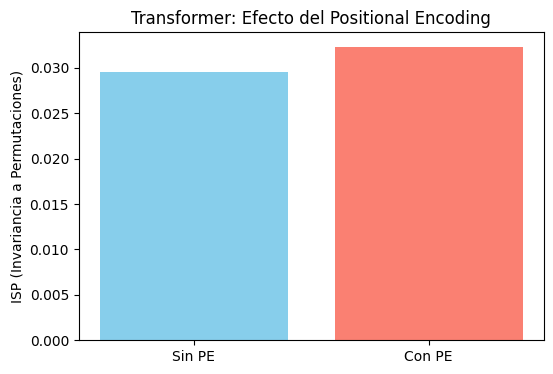

ISP sin PE  ≈ 0.029576
ISP con PE  ≈ 0.032294


In [ ]:
# ============================================
# 🧩 Mini-Experimento 1: Invariancia a permutaciones sin PE
# ============================================

# 🌡️ Objetivo:
# Mostrar que un Transformer sin Positional Encoding (PE)
# es invariante al orden temporal de las observaciones.

# -------------------------------------------------------
# 1️⃣ Librerías
# -------------------------------------------------------
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------
# 2️⃣ Generamos datos sintéticos (T,H,P)
# -------------------------------------------------------
np.random.seed(42)
T = 500  # longitud de la serie temporal
temp = 20 + 5 * np.sin(np.linspace(0, 4*np.pi, T)) + np.random.randn(T)
hum = 60 + 10 * np.cos(np.linspace(0, 2*np.pi, T)) + np.random.randn(T)
prec = np.maximum(0, np.random.randn(T) * 2)

X = np.stack([temp, hum, prec], axis=1)

# -------------------------------------------------------
# 3️⃣ Creamos dataset supervisado: ventana → siguiente valor de temperatura
# -------------------------------------------------------
L = 16  # longitud de la ventana
X_seq, y_seq = [], []
for t in range(L, len(X)):
    X_seq.append(X[t-L:t])
    y_seq.append(X[t, 0])  # predecimos la temperatura futura

X_seq = np.array(X_seq, dtype=np.float32)
y_seq = np.array(y_seq, dtype=np.float32).reshape(-1, 1)

# Dividimos en train/test
n = len(X_seq)
n_train = int(0.8 * n)
X_train, X_test = X_seq[:n_train], X_seq[n_train:]
Y_train, Y_test = y_seq[:n_train], y_seq[n_train:]

# -------------------------------------------------------
# 4️⃣ DataLoaders
# -------------------------------------------------------
batch_size = 32
dl_te = DataLoader(TensorDataset(torch.tensor(X_test), torch.tensor(Y_test)),
                   batch_size=batch_size, shuffle=False)

# -------------------------------------------------------
# 5️⃣ Definimos un Transformer Encoder
# -------------------------------------------------------
class SimpleTransformerEncoder(nn.Module):
    def __init__(self, d_in=3, d_model=32, nhead=4, num_layers=2, use_pe=False):
        super().__init__()
        self.use_pe = use_pe
        self.input_proj = nn.Linear(d_in, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_proj(x)
        if self.use_pe:
            # Agregamos codificación posicional simple (sinusoidal)
            pos = torch.arange(x.size(1), device=x.device).unsqueeze(1)
            div_term = torch.exp(torch.arange(0, x.size(2), 2, device=x.device) * (-np.log(10000.0) / x.size(2)))
            pe = torch.zeros_like(x)
            pe[:, :, 0::2] = torch.sin(pos * div_term)
            pe[:, :, 1::2] = torch.cos(pos * div_term)
            x = x + pe
        x_enc = self.encoder(x)
        x_mean = x_enc.mean(dim=1)
        return self.fc_out(x_mean)

# -------------------------------------------------------
# 6️⃣ Creamos modelos con y sin PE
# -------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_nope = SimpleTransformerEncoder(use_pe=False).to(device)
model_pe = SimpleTransformerEncoder(use_pe=True).to(device)

# -------------------------------------------------------
# 7️⃣ Tomamos un batch de prueba
# -------------------------------------------------------
xb, yb = next(iter(dl_te))
xb, yb = xb.to(device), yb.to(device)

# -------------------------------------------------------
# 8️⃣ Calculamos salidas originales
# -------------------------------------------------------
with torch.no_grad():
    y_pred_nope = model_nope(xb)
    y_pred_pe = model_pe(xb)

# -------------------------------------------------------
# 9️⃣ Aplicamos permutaciones aleatorias al orden temporal
# -------------------------------------------------------
M = 30  # número de permutaciones
isp_nope, isp_pe = [], []

for _ in range(M):
    perm = torch.randperm(xb.size(1))  # permutamos la secuencia temporal
    xb_perm = xb[:, perm, :]

    with torch.no_grad():
        y_perm_nope = model_nope(xb_perm)
        y_perm_pe = model_pe(xb_perm)

    isp_nope.append(torch.mean(torch.abs(y_perm_nope - y_pred_nope)).item())
    isp_pe.append(torch.mean(torch.abs(y_perm_pe - y_pred_pe)).item())

ISP_noPE = np.mean(isp_nope)
ISP_PE = np.mean(isp_pe)

# -------------------------------------------------------
# 🔟 Visualización
# -------------------------------------------------------
plt.figure(figsize=(6,4))
plt.bar(["Sin PE", "Con PE"], [ISP_noPE, ISP_PE], color=["skyblue","salmon"])
plt.ylabel("ISP (Invariancia a Permutaciones)")
plt.title("Transformer: Efecto del Positional Encoding")
plt.show()

print(f"ISP sin PE  ≈ {ISP_noPE:.6f}")
print(f"ISP con PE  ≈ {ISP_PE:.6f}")

#¿por qué usar ISP en lugar del MSE?
No estamos evaluando qué tan bien predice el modelo, sino qué tan sensible es al orden temporal.

El Error Cuadrático Medio (MSE) mide la precisión de las predicciones frente a los valores verdaderos.

La métrica ISP (Invarianza a Permutaciones) compara las predicciones del mismo modelo antes y después de permutar el orden de las observacione